In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import chi2_contingency

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        data = pd.read_csv(os.path.join(dirname, filename))
data.head()

/kaggle/input/hri-cs592-project/HRI_ End of study questionnaire (Responses) - Form responses 1.csv


,Timestamp,Please indicate how you do feel about the following statement. [Misty understands privacy boundaries],Please indicate how you do feel about the following statement. [Misty is trustworthy],Please indicate how you do feel about the following statement. [I would feel comfortable sharing sensitive information with Misty],Please indicate how you do feel about the following statement. [I would NOT share information with Misty],Please indicate how you do feel about the following statement. [I would feel comfortable having a conversation around Misty],Please indicate your gender,What prior exposure do you have with robots? You may mention the name of robots you have interacted with.,Please rank the following privacy notices based on how private you perceive each of them to be. [LED indicator],Please rank the following privacy notices based on how private you perceive each of them to be. [Turning around],Please rank the following privacy notices based on how private you perceive each of them to be. [Looking at laptop screen],Notice Style
0,09/11/2024 14:13:59,Strongly agree,Strongly agree,Neither agree or disagree,Neither agree or disagree,Neither agree or disagree,Woman,1,2 (Less private),1 (Most private),3 (Least private),LED Indicator
1,09/11/2024 14:35:23,Neither agree or disagree,Somewhat agree,Somewhat agree,Neither agree or disagree,Neither agree or disagree,Man,0,2 (Less private),1 (Most private),3 (Least private),Turning Away
2,13/11/2024 12:40:28,Strongly agree,Agree,Somewhat agree,Neither agree or disagree,Agree,Woman,0,2 (Less private),1 (Most private),3 (Least private),LED Indicator
3,13/11/2024 13:10:59,Somewhat disagree,Agree,Somewhat agree,Neither agree or disagree,Somewhat agree,Woman,1,2 (Less private),1 (Most private),3 (Least private),Control
4,13/11/2024 15:25:22,Agree,Somewhat agree,Neither agree or disagree,Somewhat disagree,Agree,Man,1,1 (Most private),3 (Least private),2 (Less private),Turning away


In [3]:
#preprocessing
linkert_map = {
    "Strongly agree":1,
    "Agree":2,
    "Somewhat agree":3,
    "Neither agree or disagree":4,
    "Somewhat disagree": 5,
    "Disagree":6,
    "Strongly disagree":7  
}

gender_map = {
    "Man": 1,
    "Woman": 2,
    "Non-binary": 3
}

ranking_map = {
    "1 (Most private)": 1,
    "2 (Less private)": 2,
    "3 (Least private)": 3
}

notice_style_map = {
    "LED Indicator":1,
    "Turning Away":2,
    "Turning away":2,
    "Control":3
}

prior_exposure = {
    "Yes":1,
    "No":0
}

data['Please indicate how you do feel about the following statement. [Misty understands privacy boundaries]'] = data['Please indicate how you do feel about the following statement. [Misty understands privacy boundaries]'].map(linkert_map)
data['Please indicate how you do feel about the following statement. [Misty is trustworthy]'] = data['Please indicate how you do feel about the following statement. [Misty is trustworthy]'].map(linkert_map)
data['Please indicate how you do feel about the following statement. [I would feel comfortable sharing sensitive information with Misty]'] = data['Please indicate how you do feel about the following statement. [I would feel comfortable sharing sensitive information with Misty]'].map(linkert_map)
data['Please indicate how you do feel about the following statement. [I would NOT share information with Misty]'] = data['Please indicate how you do feel about the following statement. [I would NOT share information with Misty]'].map(linkert_map)
data['Please indicate how you do feel about the following statement. [I would feel comfortable having a conversation around Misty]'] = data['Please indicate how you do feel about the following statement. [I would feel comfortable having a conversation around Misty]'].map(linkert_map)

data['Please indicate your gender'] = data['Please indicate your gender'].map(gender_map)

data['Please rank the following privacy notices based on how private you perceive each of them to be. [LED indicator]'] = data['Please rank the following privacy notices based on how private you perceive each of them to be. [LED indicator]'].map(ranking_map)
data['Please rank the following privacy notices based on how private you perceive each of them to be. [Turning around]'] = data['Please rank the following privacy notices based on how private you perceive each of them to be. [Turning around]'].map(ranking_map)
data['Please rank the following privacy notices based on how private you perceive each of them to be. [Looking at laptop screen]'] = data['Please rank the following privacy notices based on how private you perceive each of them to be. [Looking at laptop screen]'].map(ranking_map)

data['Notice Style'] = data['Notice Style'].map(notice_style_map)

data.rename(columns={'Please indicate how you do feel about the following statement. [Misty understands privacy boundaries]': 'privacy_boundaries', 
                     'Please indicate how you do feel about the following statement. [Misty is trustworthy]': 'trustworthy',
                    'Please indicate how you do feel about the following statement. [I would feel comfortable sharing sensitive information with Misty]': 'sensitive_info',
                    'Please indicate how you do feel about the following statement. [I would NOT share information with Misty]': 'share_info',
                    'Please indicate how you do feel about the following statement. [I would feel comfortable having a conversation around Misty]':'conversation',
                    'Please indicate your gender': 'gender',
                    'Please rank the following privacy notices based on how private you perceive each of them to be. [LED indicator]': 'led',
                    'Please rank the following privacy notices based on how private you perceive each of them to be. [Turning around]': 'turn_around',
                    'Please rank the following privacy notices based on how private you perceive each of them to be. [Looking at laptop screen]': 'control',
                    'Notice Style': 'notice_style',
                    'What prior exposure do you have with robots? You may mention the name of robots you have interacted with.': 'prior_exposure'}, inplace=True)

In [4]:
data.iloc[1: , :]
data.head()

,Timestamp,privacy_boundaries,trustworthy,sensitive_info,share_info,conversation,gender,prior_exposure,led,turn_around,control,notice_style
0,09/11/2024 14:13:59,1,1,4,4,4,2,1,2,1,3,1
1,09/11/2024 14:35:23,4,3,3,4,4,1,0,2,1,3,2
2,13/11/2024 12:40:28,1,2,3,4,2,2,0,2,1,3,1
3,13/11/2024 13:10:59,5,2,3,4,3,2,1,2,1,3,3
4,13/11/2024 15:25:22,2,3,4,5,2,1,1,1,3,2,2


In [5]:
def perform_t_test_gender(col_name):
    group_men = data[data['gender'] == 1][col_name]
    group_women = data[data['gender'] == 2][col_name]
    t_stat, p_value = stats.ttest_ind(group_men.dropna(), group_women.dropna(), equal_var=False)
    print(f"T-statistic for {col_name}: {t_stat}, P-value: {p_value}")

# H3: Gender
perform_t_test_gender('privacy_boundaries')
perform_t_test_gender('trustworthy')
perform_t_test_gender('sensitive_info')
perform_t_test_gender('share_info')
perform_t_test_gender('conversation')

perform_t_test_gender('led')
perform_t_test_gender('turn_around')
perform_t_test_gender('control')

T-statistic for privacy_boundaries: 0.7254762501100116, P-value: 0.49351414969984064
T-statistic for trustworthy: 1.8650096164806278, P-value: 0.09315880942486207
T-statistic for sensitive_info: 2.497421350525749, P-value: 0.03924400615576969
T-statistic for share_info: 0.18318582636182823, P-value: 0.8594786863511377
T-statistic for conversation: 1.6712580435934674, P-value: 0.14146358696772432
T-statistic for led: -1.0000000000000004, P-value: 0.36321746764912244
T-statistic for turn_around: 0.9999999999999997, P-value: 0.3632174676491228
T-statistic for control: -0.9999999999999993, P-value: 0.363217467649123


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


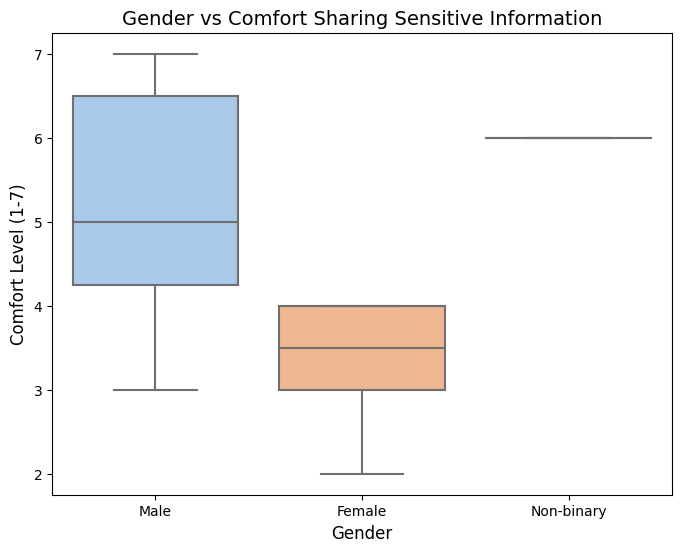

In [6]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='sensitive_info', data=data, palette='pastel')
plt.xticks(ticks=[0,1,2], labels=['Male', 'Female', "Non-binary"])
# Add title and labels
plt.title("Gender vs Comfort Sharing Sensitive Information", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Comfort Level (1-7)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [7]:
def perform_t_test_notice_style(col_name):
    group_led = data[data['notice_style'] == 1][col_name]
    group_turn = data[data['notice_style'] == 2][col_name]
    group_control = data[data['notice_style'] == 3][col_name]
    f_stat, p_value = stats.f_oneway(group_led.dropna(), group_turn.dropna(), group_control.dropna())
    print(f"F-statistic for {col_name}: {f_stat}, P-value: {p_value}")

# H3: Gender
perform_t_test_notice_style('privacy_boundaries')
perform_t_test_notice_style('trustworthy')
perform_t_test_notice_style('sensitive_info')
perform_t_test_notice_style('share_info')
perform_t_test_notice_style('conversation')
perform_t_test_notice_style('prior_exposure')
perform_t_test_notice_style('led')
perform_t_test_notice_style('turn_around')
perform_t_test_notice_style('control')

F-statistic for privacy_boundaries: 4.488714877936436, P-value: 0.04062683937937654
F-statistic for trustworthy: 1.6782092505565174, P-value: 0.23526098312815483
F-statistic for sensitive_info: 0.06566604127579737, P-value: 0.9368439273347833
F-statistic for share_info: 2.896528250510551, P-value: 0.10178154863407997
F-statistic for conversation: 0.017174976579577395, P-value: 0.9830006024422597
F-statistic for prior_exposure: 0.6980056980056979, P-value: 0.5202781959717775
F-statistic for led: 0.0, P-value: 1.0
F-statistic for turn_around: 1.1538461538461535, P-value: 0.354092597961426
F-statistic for control: 3.461538461538462, P-value: 0.07204491900081343


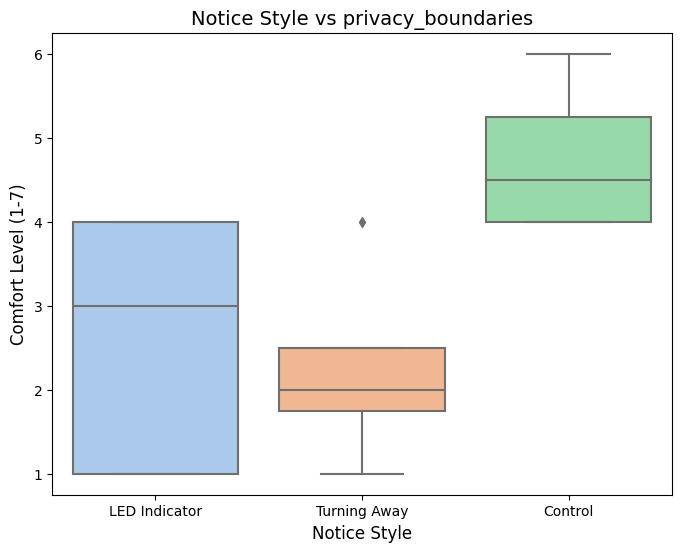

In [8]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='notice_style', y='privacy_boundaries', data=data, palette='pastel')
plt.xticks(ticks=[0,1,2], labels=['LED Indicator', 'Turning Away', "Control"])
# Add title and labels
plt.title("Notice Style vs privacy_boundaries", fontsize=14)
plt.xlabel("Notice Style", fontsize=12)
plt.ylabel("Comfort Level (1-7)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

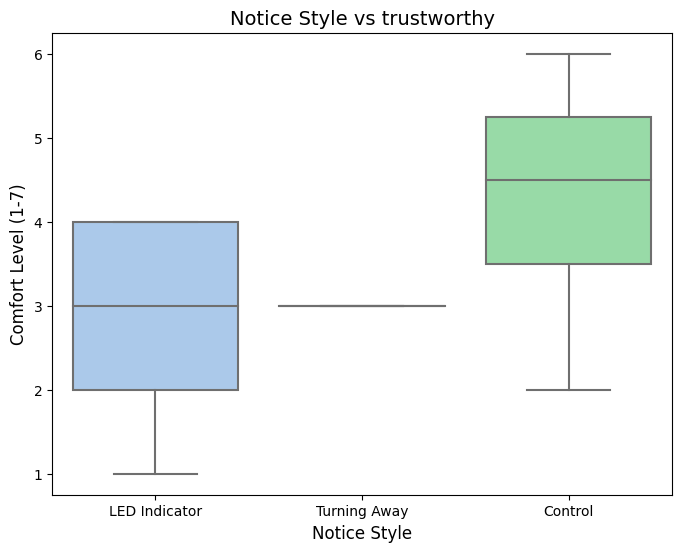

In [9]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='notice_style', y='trustworthy', data=data, palette='pastel')
plt.xticks(ticks=[0,1,2], labels=['LED Indicator', 'Turning Away', "Control"])
# Add title and labels
plt.title("Notice Style vs trustworthy", fontsize=14)
plt.xlabel("Notice Style", fontsize=12)
plt.ylabel("Comfort Level (1-7)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

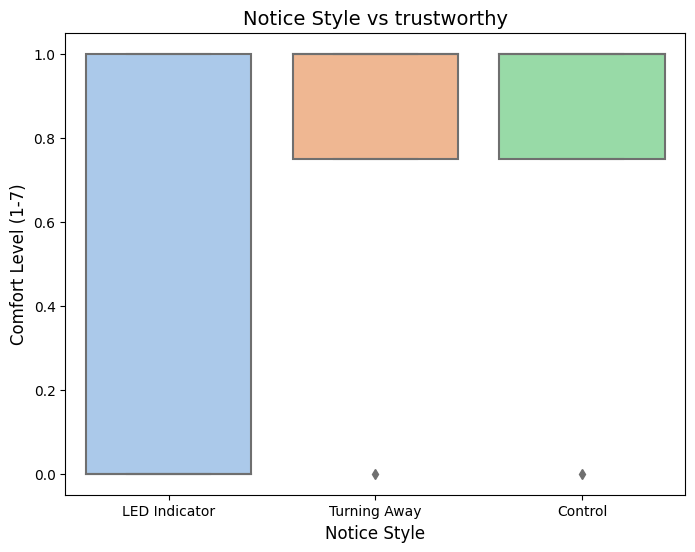

In [10]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='notice_style', y='prior_exposure', data=data, palette='pastel')
plt.xticks(ticks=[0,1,2], labels=['LED Indicator', 'Turning Away', "Control"])
# Add title and labels
plt.title("Notice Style vs trustworthy", fontsize=14)
plt.xlabel("Notice Style", fontsize=12)
plt.ylabel("Comfort Level (1-7)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [11]:
def perform_t_test_prior(col_name):
    group_exp = data[data['prior_exposure'] == 1][col_name]
    group_no_exp = data[data['prior_exposure'] == 0][col_name]
    t_stat, p_value = stats.ttest_ind(group_exp.dropna(), group_no_exp.dropna(), equal_var=False)
    print(f"T-statistic for {col_name}: {t_stat}, P-value: {p_value}")

# H3: Gender
perform_t_test_prior('privacy_boundaries')
perform_t_test_prior('trustworthy')
perform_t_test_prior('sensitive_info')
perform_t_test_prior('share_info')
perform_t_test_prior('conversation')

perform_t_test_prior('led')
perform_t_test_prior('turn_around')
perform_t_test_prior('control')

T-statistic for privacy_boundaries: -0.4504426164614507, P-value: 0.6614608843770635
T-statistic for trustworthy: -1.017173550743708, P-value: 0.3419147219307781
T-statistic for sensitive_info: -1.0108896132708942, P-value: 0.352238509142989
T-statistic for share_info: 0.16834512458535844, P-value: 0.8726418724365604
T-statistic for conversation: -1.5920595043359824, P-value: 0.15762244497424696
T-statistic for led: 0.0, P-value: 1.0
T-statistic for turn_around: 1.0, P-value: 0.3506166628202075
T-statistic for control: -1.5275252316519468, P-value: 0.17047066078705375


/opt/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


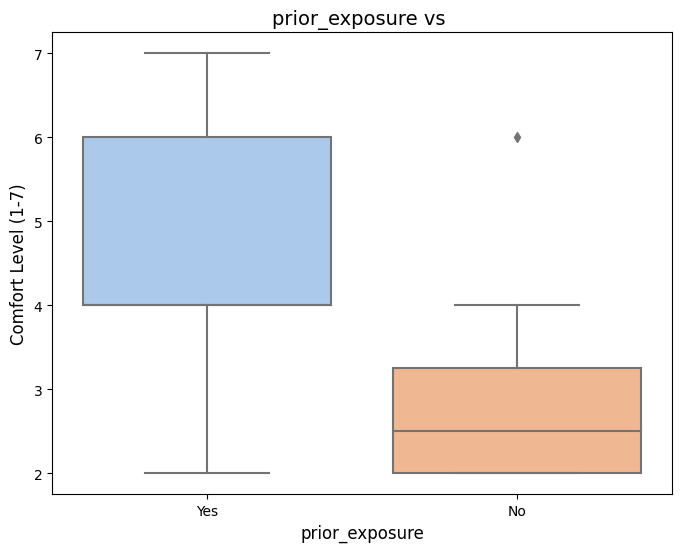

In [12]:
# Create a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='prior_exposure', y='conversation', data=data, palette='pastel')
plt.xticks(ticks=[0,1], labels=['Yes', 'No'])
# Add title and labels
plt.title("prior_exposure vs ", fontsize=14)
plt.xlabel("prior_exposure", fontsize=12)
plt.ylabel("Comfort Level (1-7)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

In [13]:
# Create a contingency table
contingency_table = pd.crosstab(data['notice_style'], data['sensitive_info'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
# print("Contingency Table:")
# print(contingency_table)
print("\nChi-squared Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("\nExpected Frequencies:")
print(expected)


Chi-squared Statistic: 8.233333333333333
P-value: 0.6060568749256816
Degrees of Freedom: 10

Expected Frequencies:
[[0.38461538 1.15384615 1.53846154 0.76923077 0.38461538 0.76923077]
 [0.30769231 0.92307692 1.23076923 0.61538462 0.30769231 0.61538462]
 [0.30769231 0.92307692 1.23076923 0.61538462 0.30769231 0.61538462]]
